# XGBoost Model for predicting position

### Description
This notebook implements an XGBoost model to classify racket impact zones (C, S, V) using audio features extracted from vibration recordings. Frequency bands and their energies are computed from FFT spectra and used as input features. The model is trained and evaluated with accuracy metrics to assess performance.

Import

In [14]:
import os
import glob
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.io import wavfile
from scipy.fft import fft
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from scipy.signal import hilbert
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import openpyxl


### Import Tools Functions

In [5]:
import sys
# Reach the project root
notebook_path = os.path.abspath('')
project_root = os.path.abspath(os.path.join(notebook_path, '../../../'))
functions_path = os.path.join(project_root, 'Functions')

# Add Functions folder
if functions_path not in sys.path:
    sys.path.append(functions_path)

Readwav function

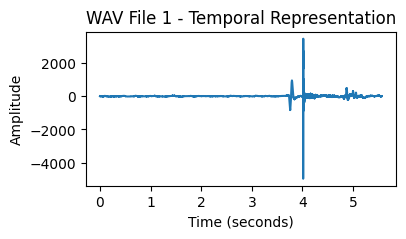

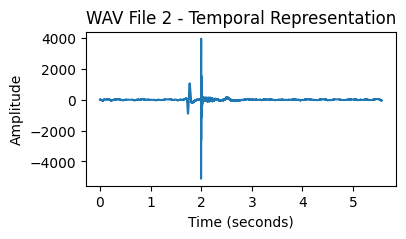

In [7]:
from readWavFolder import readWavFolder
    
samplerateVect,testWavFileVect,files = readWavFolder("../../../Data/Sound/P1")

for i, wav_data in enumerate(testWavFileVect[:2]):
    plt.figure(figsize=(4, 2))
    time_axis = [x / samplerateVect[i] for x in range(len(wav_data))]
    plt.plot(time_axis, wav_data[:, 1])  # Plot only the n channel
    plt.title(f"WAV File {i + 1} - Temporal Representation")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.show()


Spectrum

In [9]:
from spectrumFromWav import spectrumFromWav

Extract each peak and store

In [10]:
from extractPeakFromSignal import extractPeakFromSignal


Energy per frequency band (e.g. third octave)

In [11]:
from energy_per_frequency_band_from_spectrum import energy_per_frequency_band_from_spectrum

envelope of the time signal (see Hilbert transform)

In [17]:
import re
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

from readWavFolder import readWavFolder
from spectrumFromWav import spectrumFromWav
from energy_per_frequency_band_from_spectrum import energy_per_frequency_band_from_spectrum

# Liste des types de raquettes et zones
racket_names = {"RB": 1, "RO": 2, "RR": 3, "RV": 4}
zone_names = {"C": 1, "S": 2, "V": 3}

results = []

for band_width in range(20, 21, 5):
    X_Hz = []
    X_Amplitude = []
    Y_Label = []
    print("band width :", band_width)

    for raquetteType in racket_names:
        dossier_raquette = f"../../../Data/Sound/P1"
        samplerateVect, WavFileVect, filesName = readWavFolder(dossier_raquette)

        for i in range(len(WavFileVect)):
            filename = filesName[i]

            # Utilisation de regex pour extraire la zone
            match = re.search(r'_(C|S|V)_', filename)
            if match:
                zone = match.group(1)
            else:
                continue  # Fichier ignoré s'il ne contient pas une zone valide

            wav_data = WavFileVect[i]

            # Gérer mono/stéréo sans modifier les fonctions
            if wav_data.ndim == 1:
                wav_data = np.stack((wav_data, wav_data), axis=-1)
            elif wav_data.shape[1] == 1:
                wav_data = np.concatenate((wav_data, wav_data), axis=1)

            spectrum = spectrumFromWav(wav_data)

            freqs = np.fft.fftfreq(len(spectrum) * 2, d=1 / samplerateVect[i])[:len(spectrum)]
            mask = (freqs >= 150) & (freqs <= 1000)
            filtered_freqs = freqs[mask]
            filtered_spectrum = spectrum[mask]

            band_energies, band_frequencies = energy_per_frequency_band_from_spectrum(
                filtered_spectrum,
                filtered_freqs,
                band_width
            )

            X_Hz.append(band_frequencies)
            X_Amplitude.append(band_energies)
            Y_Label.append(zone)

    # Normalisation
    X_Amplitude = [
        amp / np.max(amp) if np.max(amp) != 0 else amp
        for amp in X_Amplitude
    ]

    # Padding
    max_length = max(
        max(len(peaks) for peaks in X_Hz),
        max(len(amps) for amps in X_Amplitude)
    )
    X_Hz_padded = [np.pad(peaks, (0, max_length - len(peaks)), constant_values=0) for peaks in X_Hz]
    X_Amplitude_padded = [np.pad(amps, (0, max_length - len(amps)), constant_values=0) for amps in X_Amplitude]

    X = np.hstack((np.array(X_Hz_padded), np.array(X_Amplitude_padded)))
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(Y_Label)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=True
    )

    n_estimators_list = [50, 100, 200]
    max_depth_list = [3, 5, 7]
    learning_rate_list = [0.01, 0.1, 0.2]

    for n_estimators in n_estimators_list:
        for max_depth in max_depth_list:
            for learning_rate in learning_rate_list:
                model = XGBClassifier(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    learning_rate=learning_rate,
                    eval_metric='mlogloss'
                )
                model.fit(X_train, y_train)

                y_pred_test = model.predict(X_test)
                y_pred_train = model.predict(X_train)

                accuracy_test = accuracy_score(y_test, y_pred_test)
                accuracy_train = accuracy_score(y_train, y_pred_train)

                results.append({
                    'band_width': band_width,
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'learning_rate': learning_rate,
                    'accuracy_train': accuracy_train,
                    'accuracy_test': accuracy_test
                })

# Export des résultats
results_df = pd.DataFrame(results)
results_df.to_excel("XGBOOST_ZONE_P1_Energie.xlsx", index=False)

print("Results have been saved to 'XGBOOST_ZONE_P1_Energie.xlsx'.")


band width : 20
Results have been saved to 'XGBOOST_ZONE_P1_Energie.xlsx'.
